In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from imp import reload
import torch.nn as nn

import vnn2
reload(vnn2)
import local2d

In [2]:
in_channels = 4
out_channels = 4
h_in = 24
w_in = 24
kernel_size = 5

lc = local2d.Local2d(in_channels, out_channels, kernel_size, h_in, w_in, stride=1, padding=3, bias=True)

In [105]:
x = torch.randn(128, in_channels, h_in, w_in)
out = lc(x)

In [106]:
loss = out.sum()

In [107]:
loss.backward()

In [108]:
g1 = lc.weight.grad.clone()

In [111]:
W = lc.weight.detach().clone()
W.grad = None
W.requires_grad = True
out = local2d.lc_forward(x.clone(), W, stride=1, padding=3)

In [112]:
loss = out.sum()

In [113]:
loss.backward()

In [114]:
g2 = W.grad.clone()

In [117]:
(g1-g2).abs().max()

tensor(1.1444e-05)

In [13]:
reload(vnn2)
def make_mnist_vec_lc(mono=False):
    model = nn.Sequential(
        vnn2.VecLocal2d(10, 10, 32, 3, h_in=28, w_in=28, stride=1, padding=1, first_layer=True, mono=mono),
        vnn2.ctReLU(10, 32, 28, 28),
        vnn2.AvgPool2d(2),
        vnn2.VecLocal2d(10, 32, 32, 3, h_in=14, w_in=14, stride=1, padding=1, mono=mono),
        vnn2.ctReLU(10, 32, 14, 14),
        vnn2.AvgPool2d(2), #7 by 7
        vnn2.Flatten(),
        vnn2.Linear(10, 1568, 1024, mono=mono),
        vnn2.tReLU(10, 1024),
        vnn2.Linear(10, 1024, 1, mono=mono))
    return model

def make_cifar_vec_lc(mono=False):
    model = nn.Sequential(
        vnn2.VecLocal2d(10, 30, 128, 5, h_in=32, w_in=32, stride=1, padding=2, first_layer=True, mono=mono),
        vnn2.ctReLU(10, 128, 32, 32),
        vnn2.AvgPool2d(2),
        vnn2.VecLocal2d(10, 128, 128, 5, h_in=16, w_in=16, stride=1, padding=2, mono=mono),
        vnn2.ctReLU(10, 128, 16, 16),
        vnn2.AvgPool2d(2),
        vnn2.VecLocal2d(10, 128, 128, 2, h_in=8, w_in=8, stride=2, padding=0, mono=mono),
        vnn2.ctReLU(10, 128, 4, 4),
        vnn2.Flatten(),
        vnn2.Linear(10, 2048, 1024, mono=mono),
        vnn2.tReLU(10, 1024),
        vnn2.Linear(10, 1024, 1, mono=mono))
    return model

model = make_mnist_vec_lc(mono=False)



In [14]:
model = model.to(0)

In [15]:
input = torch.randn(64, 10, 10, 28, 28).to(0)
labels = torch.randint(0, 10, (64,)).to(0)

In [16]:
reload(vnn2)
output = model(input)[..., 0]
vnn2.set_model_grads(model, output, labels, learning_rule="bp", reduction="mean")
g1 = [param.grad for (name, param) in model.named_parameters() if name[-2:] != ".t"]
#22s

A torch.Size([640, 10, 28, 28])
B torch.Size([640, 10, 30, 30])
torch.Size([64, 10, 32, 28, 28])
torch.Size([64, 10, 32, 28, 28])
A torch.Size([640, 32, 14, 14])
B torch.Size([640, 32, 16, 16])
torch.Size([64, 10, 32, 14, 14])
torch.Size([64, 10, 32, 14, 14])


In [17]:
loss_fn = nn.CrossEntropyLoss(reduction="mean")
for (name, param) in model.named_parameters():
    if name[-2:] != ".t":
        param.grad = None
        param.requires_grad = True
output = model(input)[..., 0]
loss = loss_fn(output, labels)
loss.backward()
g2 = [param.grad for (name, param) in model.named_parameters() if name[-2:] != ".t"]
#44 s

A torch.Size([640, 10, 28, 28])
B torch.Size([640, 10, 30, 30])
torch.Size([64, 10, 32, 28, 28])
torch.Size([64, 10, 32, 28, 28])
A torch.Size([640, 32, 14, 14])
B torch.Size([640, 32, 16, 16])
torch.Size([64, 10, 32, 14, 14])
torch.Size([64, 10, 32, 14, 14])


In [18]:
[(g1[i]-g2[i]).abs().max() for i in range(len(g1))]

[tensor(6.1118e-10, device='cuda:0'),
 tensor(1.8917e-10, device='cuda:0'),
 tensor(4.6566e-09, device='cuda:0'),
 tensor(9.8953e-10, device='cuda:0'),
 tensor(1.8626e-08, device='cuda:0'),
 tensor(1.1642e-09, device='cuda:0'),
 tensor(4.4703e-08, device='cuda:0'),
 tensor(7.4506e-09, device='cuda:0')]

In [19]:
from scipy.stats import pearsonr

[pearsonr(g1[i].cpu().flatten().numpy(), g2[i].cpu().flatten().numpy()) for i in range(len(g1))]

[(0.9999999999998788, 0.0),
 (0.9999999999998812, 0.0),
 (0.999999999999877, 0.0),
 (0.9999999999998916, 0.0),
 (0.9999999999999359, 0.0),
 (0.999999999999995, 0.0),
 (0.9999999999999892, 0.0),
 (0.9999999999999925, 1.4211981301389257e-56)]

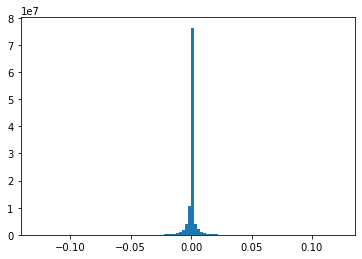

In [26]:
plt.hist(diff, bins=100)
plt.show()

In [10]:
a = g1[5].numpy().flatten()
b = g2[5].numpy().flatten()

In [11]:
from scipy.stats import pearsonr
pearsonr(a, b)

(0.9999999999999624, 0.0)

In [36]:
for name, param in model.named_parameters():
    print(name)

0.weight
0.bias
1.t
3.weight
3.bias
4.t
6.weight
6.bias
7.t
9.weight
9.bias
10.t
11.weight
11.bias
